##Previsão de Séries Temporais Aplicada a Vendas no Varejo: Um Estudo de Caso

A análise e a previsão de séries temporais, cada vez mais, têm desempenhado um papel importante no processo de definição de estratégias empresariais.

Este trabalho se propõe a explorar a aplicação das técnicas de previsão de séries temporais em um cenário específico: setor de varejo.

Serão aplicados:
1. modelo de rede neural, e
2. modelo random forest.

No contexto do varejo, entender e tentar antecipar a procura de clientes abre a possibilidade para melhor otimização de estoques e alocação de recursos tanto financeiros quanto humanos.

Neste estudo de caso, analisaremos um conjunto de dados históricos de vendas de uma loja de brinquedos ao longo de um período de cinco anos.

Nosso objetivo é aplicar alguns modelos de previsão de séries temporais e verificar os resultados que cada um vai atingir.

Para isso, será necessário inicialmente fazer uma análise exploratório de dados que vai mostrar a estrutura, as estatísticas principais e possíveis sazonalidade e tendências.


##1. Modelo Rede Neural

In [ ]:
# Inicialmente vamos importar as bibliotecas necessárias para nossa análise

import pandas as pd #biblioteca necessária para análise e manipulação de dados
import numpy as np #essencial para análise númerica complexa e manipulação de dados
from datetime import datetime, timedelta #necessária para formatação e manipulação de datas e horários
import holidays #extrai feriados na base de datas analisadas
import random # biblioteca que trabalha com números aleatórios
from sklearn.model_selection import train_test_split #bibliotea de machine learnig usada para separação de dados de teste e treino
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # biblioteca que trabalha com mêtricas para avaliação de modelos
import seaborn as sb #biblioteca para visualização de dados
import seaborn as sns #biblioteca para visualização de dados
import matplotlib.pyplot as plt #biblioteca para plotagem de gráficos de dados
import matplotlib.pyplot as mpp #biblioteca para personalizar gráficos



In [ ]:
# Os dados de venda estão no arqivo do formato csv e serão importados e lidos

data=pd.read_csv("data.csv")

In [ ]:
# Vamos converter as datas do formato string para o formato data

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

In [ ]:
# Será incluida uma coluna que deve apresentar os feriados no Brasil
br_holidays = holidays.Brazil()

# Função para verificar se uma data é um feriado
def IsHoliday(row):
    return 1 if row['Date'] in br_holidays else 0

# Vamos aplicar a função à coluna 'Date' e criar uma nova coluna 'IsHoliday'
data['IsHoliday'] = data.apply(IsHoliday, axis=1)

br_holidays

{datetime.date(2018, 1, 1): 'Confraternização Universal', datetime.date(2018, 3, 30): 'Sexta-feira Santa', datetime.date(2018, 4, 21): 'Tiradentes', datetime.date(2018, 5, 1): 'Dia do Trabalhador', datetime.date(2018, 9, 7): 'Independência do Brasil', datetime.date(2018, 10, 12): 'Nossa Senhora Aparecida', datetime.date(2018, 11, 2): 'Finados', datetime.date(2018, 11, 15): 'Proclamação da República', datetime.date(2018, 12, 25): 'Natal', datetime.date(2018, 2, 12): 'Carnaval', datetime.date(2018, 2, 13): 'Carnaval', datetime.date(2018, 2, 14): 'Início da Quaresma', datetime.date(2018, 5, 31): 'Corpus Christi', datetime.date(2018, 10, 28): 'Dia do Servidor Público', datetime.date(2018, 12, 24): 'Véspera de Natal', datetime.date(2018, 12, 31): 'Véspera de Ano-Novo', datetime.date(2019, 1, 1): 'Confraternização Universal', datetime.date(2019, 4, 19): 'Sexta-feira Santa', datetime.date(2019, 4, 21): 'Tiradentes', datetime.date(2019, 5, 1): 'Dia do Trabalhador', datetime.date(2019, 9, 7): '

In [ ]:
# Vamos criar a nova coluna 'DayOfWeek' onde 1 representa segunda-feira
data['DayOfWeek'] = data['Date'].dt.dayofweek+1

In [ ]:
# Vamos criar a nova coluna 'DayName' com o nome do dia da semana
data['DayName'] = data['Date'].dt.day_name()

In [ ]:
# Vamos desmembrar a couna Date em três colunas com dados do dia, mês e ano

data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year


In [ ]:
# Será criado o dataframe
df = pd.DataFrame(data)

df.head()

,Date,Sales,Stock,Price,IsHoliday,DayOfWeek,DayName,Day,Month,Year
0,2018-12-01,7388,9,5,0,6,Saturday,1,12,2018
1,2018-12-02,4434,23,9,0,7,Sunday,2,12,2018
2,2018-12-03,5056,20,5,0,1,Monday,3,12,2018
3,2018-12-04,6146,9,8,0,2,Tuesday,4,12,2018
4,2018-12-05,6877,5,4,0,3,Wednesday,5,12,2018


In [ ]:
# Vamos conhecer um pouco os dados

df.describe()

,Sales,Stock,Price,IsHoliday,DayOfWeek,Day,Month,Year
count,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000
mean,5621.756464,18.124474,5.456404,0.035478,3.959711,15.728803,6.352375,2020.781720
std,3232.383383,10.356034,2.881597,0.185040,1.993416,8.764216,3.463364,1.384495
min,161.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2018.000000
25%,3603.500000,10.000000,3.000000,0.000000,2.000000,8.000000,3.000000,2020.000000
50%,4902.000000,18.000000,5.000000,0.000000,4.000000,16.000000,6.000000,2021.000000
75%,6625.500000,27.000000,8.000000,0.000000,6.000000,23.000000,9.000000,2022.000000
max,31821.000000,35.000000,10.000000,1.000000,7.000000,31.000000,12.000000,2023.000000


<ipython-input-197-c9ad0e7d2eef>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr(method='pearson')


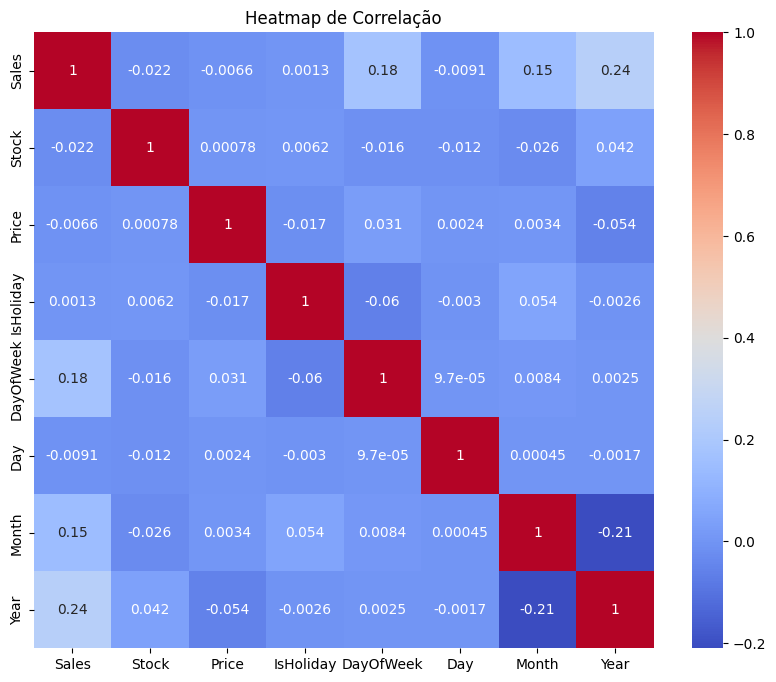

In [ ]:
# Analisar correlação entre os dados - O matriz abaixo mostra que não há correlação significativa entre os dados.
# Com isso, vamos focar a nossa analise na coluna Sales.

# Gerar a matriz de correlação
correlation_matrix = df.corr(method='pearson')

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação')
plt.show()

In [ ]:
# Vamos definir a coluna Date como index

df.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

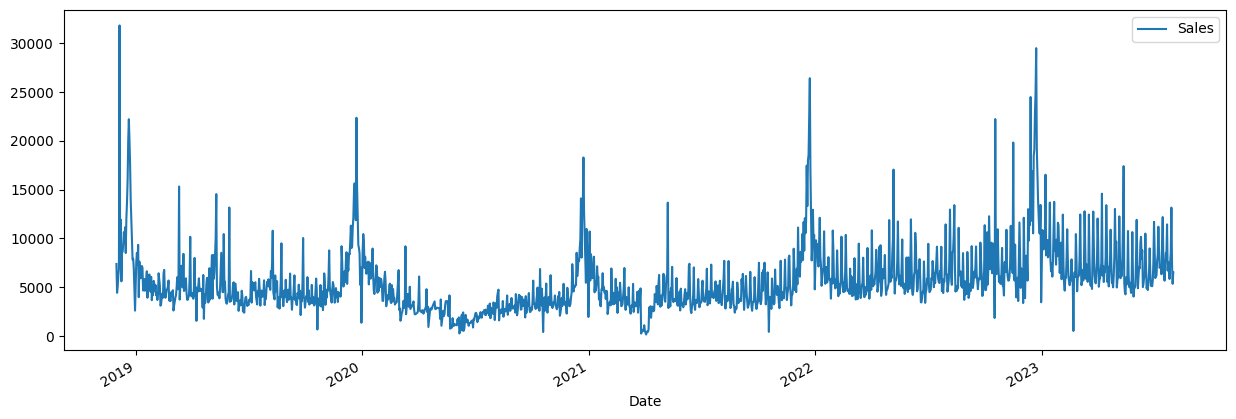

In [ ]:
# Será plotado o gráfico de venda

df['Sales'].plot(figsize = (15,5), legend = True)

In [ ]:
# Será importada a biblioteca adicional para visualização de gráficos de função de autocorrelação e função de autocorrelação parcial

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

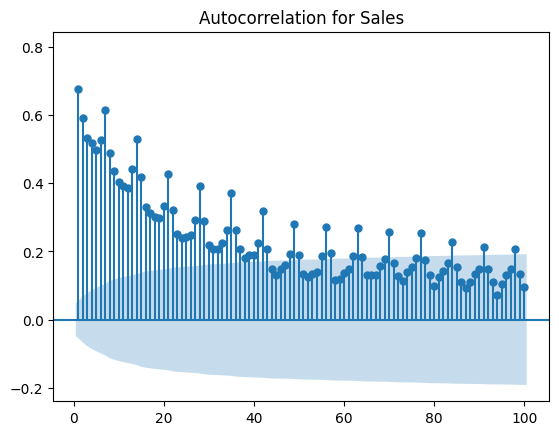

In [ ]:
plot_acf(df['Sales'], lags = 100, title='Autocorrelation for Sales', zero=False, auto_ylims=True)
mpp.show()



A interpretação do gráfico envolve análise de picos. Os picos que se estendem além da área pintada podem indicar padrões de sazonalidade. No nosso caso cada sétimo pico é maior que o anterior e o posterior dele.

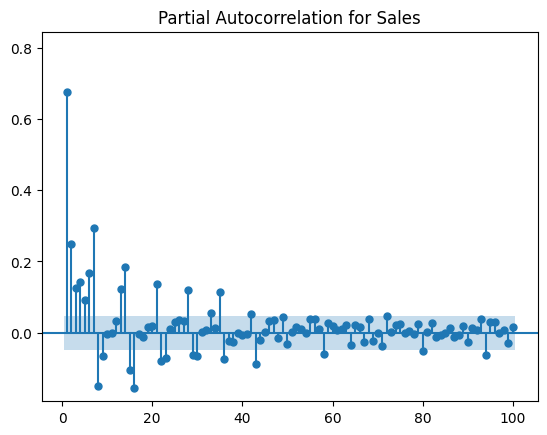

In [ ]:
plot_pacf(df['Sales'], lags = 100, title='Partial Autocorrelation for Sales', zero=False, auto_ylims=True)
mpp.show()


Nesse caso o primeiro pico no gráfico PACF é maior comparado com os outros que diminuírem gradualmente. Podemos concluir que o valor atual pode depender apenas do pico 1 (lag 1) e mostra sezonalidade semanal.

In [ ]:
# Para entender melhor a sazonalidade será feita a decomposição de série.

from statsmodels.tsa.seasonal import seasonal_decompose

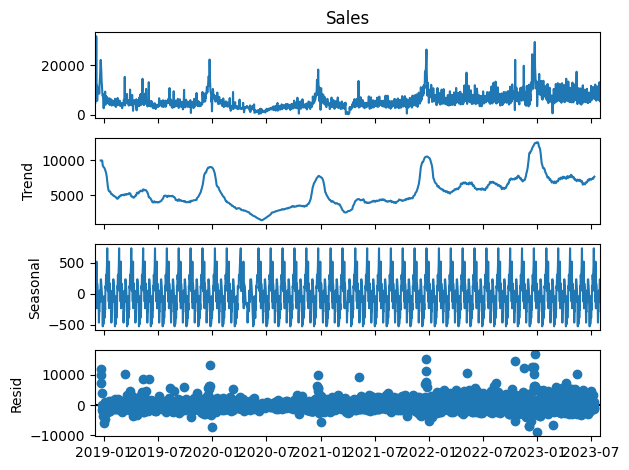

In [ ]:
# Será aplicado o modelo aditivo o que significa que os componentes (tendência, sazonalidade e resíduos) serão somados para reconstruir a série original.

sd_sales = seasonal_decompose(df['Sales'], model='additive', period = 40)
sd_sales.plot()
mpp.show()

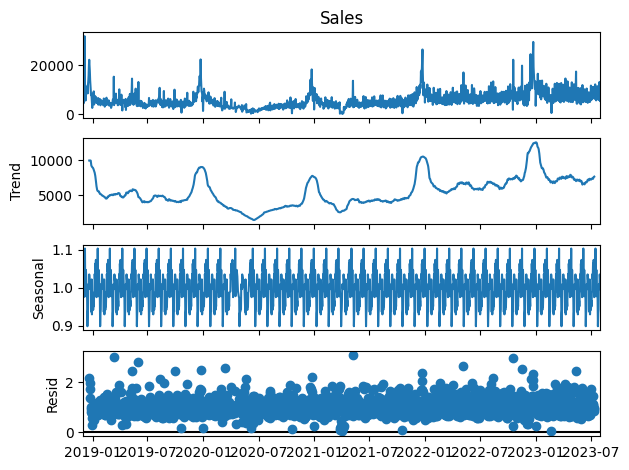

In [ ]:
# Uso de modelo multiplicativo significa que os componentes (tendência, sazonalidade e resíduos) serão multiplicados para reconstruir a série original.
sd_sales = seasonal_decompose(df['Sales'], model='multiplicative', period = 40)
sd_sales.plot()
mpp.show()

#Construção de Rede Neural usando a biblioteca Keras

In [ ]:
from keras.callbacks import History #biblioteca para construir e treinar redes neurais mostrando o histórico do progresso.
import tensorflow as tf #biblioteca para desenvolvimento de redes neurais
from sklearn.preprocessing import MinMaxScaler #biblioteca para normalização de dados dentro de uma intervalo, geralmente entre 0 e 1.


# Vamos eeparar os dados em treinamento e teste
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

# Escalonar os dados para o intervalo [-1, 1]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data['Sales'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['Sales'].values.reshape(-1, 1))

Na próxima etapa serão definidos os parâmetros da rede neural:
1. window_size - tamanho de sequiência de dados originais
2. modelo de rede - modelo pode conter uma ou mais camadas o que define a complexidade de modelo
3. epochs - número de vezes que um algoritmo de aprendizado percorre o conjunto completo de dados de treinamento durante o processo de treinamento de um modelo de machine learning
4. batch_size - representa a quantidade de dados usados em cada iteração do algoritmo

Modelo simples é composto de uma primeira camada da rede LSTM (Long Short-Term Memory) com 64 unidades (neurônios), a segunda camada totalmente conectada (dense) com 32 unidades e uma camada se saída.

Exp:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])


Um modelo mais complexo pode conter mais de uma camada LSTM. Pode conter uma camada de dropout que desativa aleatoriamente uma percentagem definida de unidades de entrada tentando evitar, dessa forma, a possibilidade de se ter overfitting.

Exp:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)

In [ ]:
# Vamos preparar os dados para treinamento
window_size = 100
X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Vamos construir o modelo de rede neural simples
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Esse seria um exemplo de modelo de rede neural com duas camadas
#model =tf.keras.models.Sequential([
 #   tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
  #  tf.keras.layers.Dropout(0.2),
   # tf.keras.layers.LSTM(64, activation='relu'),
    #tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dense(1)
#])

In [ ]:
# Vamos compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Vamos treinar o modelo sem callbacks
history = model.fit(X_train, y_train, epochs=500, batch_size=14, validation_split=0.1)

Epoch 1/500
80/80 [==============================] - 7s 63ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 2/500
80/80 [==============================] - 4s 48ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 3/500
80/80 [==============================] - 4s 52ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 4/500
80/80 [==============================] - 5s 63ms/step - loss: 0.0032 - val_loss: 0.0068
Epoch 5/500
80/80 [==============================] - 4s 49ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 6/500
80/80 [==============================] - 4s 50ms/step - loss: 0.0031 - val_loss: 0.0067
Epoch 7/500
80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 8/500
80/80 [==============================] - 4s 46ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 9/500
80/80 [==============================] - 4s 48ms/step - loss: 0.0031 - val_loss: 0.0054
Epoch 10/500
80/80 [==============================] - 5s 63ms/step - loss: 0.0030 - val_loss: 0.0053

In [ ]:
# Para modelos mais complexos o treinamento pode se feito com callbacks para parar o treinamento cedo se não houver melhoria
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#history = model.fit(X_train, y_train, epochs=100, batch_size=5, validation_split=0.1, callbacks=[early_stopping])

In [ ]:
# Vamos preparar os dados de teste
X_test = []
y_test = []
for i in range(window_size, len(test_scaled)):
    X_test.append(test_scaled[i-window_size:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Fazer previsões no conjunto de teste
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predictions_scaled = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_scaled)

# Avaliar as previsões
mae = mean_absolute_error(test_data['Sales'][window_size:], predictions)
mse = mean_squared_error(test_data['Sales'][window_size:], predictions)
r2 = r2_score(test_data['Sales'][window_size:], predictions)

# Exibir as métricas de avaliação
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)


8/8 [==============================] - 0s 18ms/step
Mean Absolute Error (MAE): 1916.4457001911212
Mean Squared Error (MSE): 9599514.750538334
R^2 Score: 0.30934478062640824


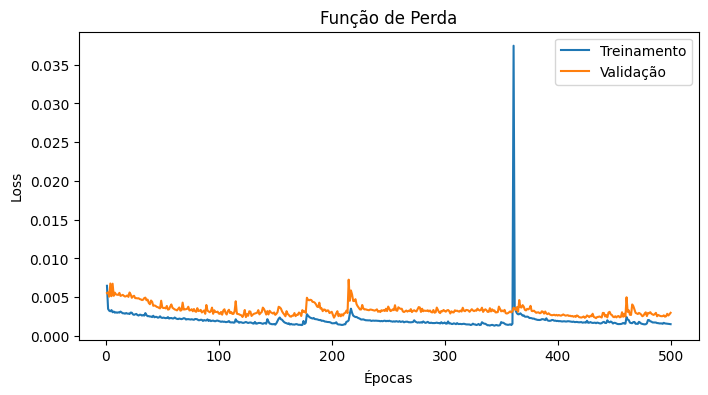

In [ ]:
# Extrair as perdas de treinamento e validação do histórico
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar o gráfico da função de perda ao longo das épocas
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, label='Treinamento')
plt.plot(epochs, val_loss, label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Função de Perda')
plt.legend()
plt.show()

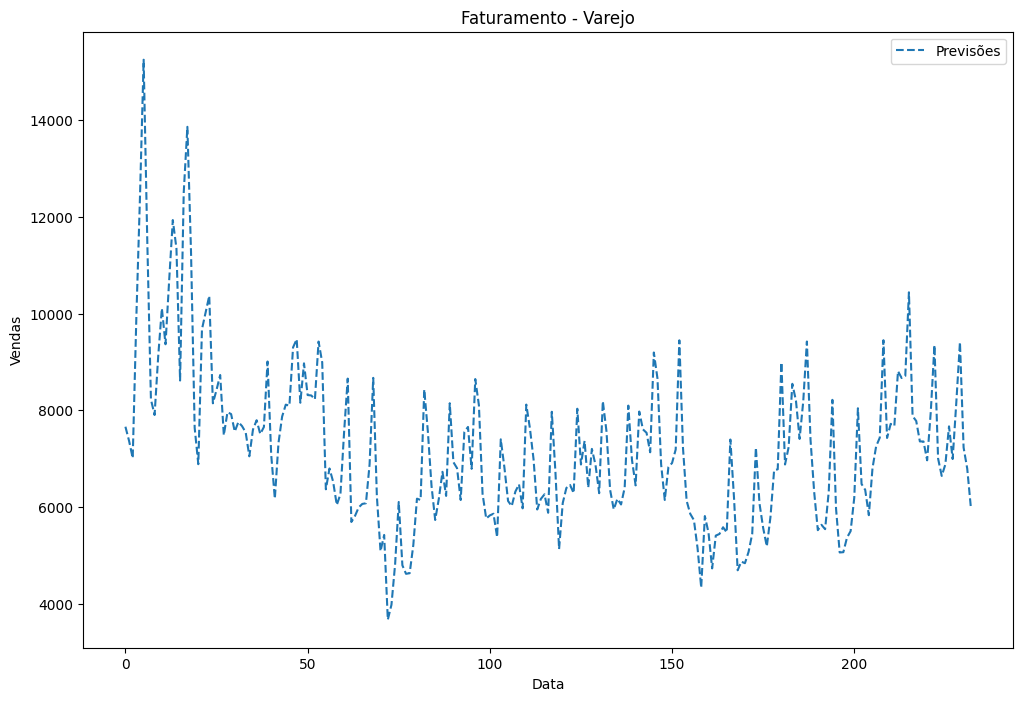

In [ ]:
# Será plotada a previsão de venda

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
plt.plot(predictions, label='Previsões', linestyle='dashed')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Faturamento - Varejo')
plt.legend()
plt.show()

Os parâmetros usados no treinamento desse modelo são:

* window_size - 100;

* modelo de rede - simples com uma camada;

* epochs - 500;

* batch_size - 14.

Com esses parâmetros conseguimos os seguintes desempenhos:

Mean Absolute Error (MAE): 1916.4457001911212

O MAE de aproximadamente 1916 indica que, em média, as previsões do modelo estão desviando do valor real em cerca de 1803 unidades.

Mean Squared Error (MSE): 9599514.750538334

O MSE de aproximadamente 8282602 indica que o modelo tem um erro médio quadrado que sugerir que existem alguns pontos com erros significativos.

R^2 Score: 0.30934478062640824

O R^2 Score de aproximadamente 0.404 indica que cerca de 31% da variabilidade dos dados de saída é capturada pelo modelo, o que sugere que o modelo pode explicar apenas uma parte, mas não a totalidade, da variabilidade dos dados.



Segue abaixo a tabela com parâmetros usado nas outras tentativas de treinamento e os resultados obtidos para cada uma.

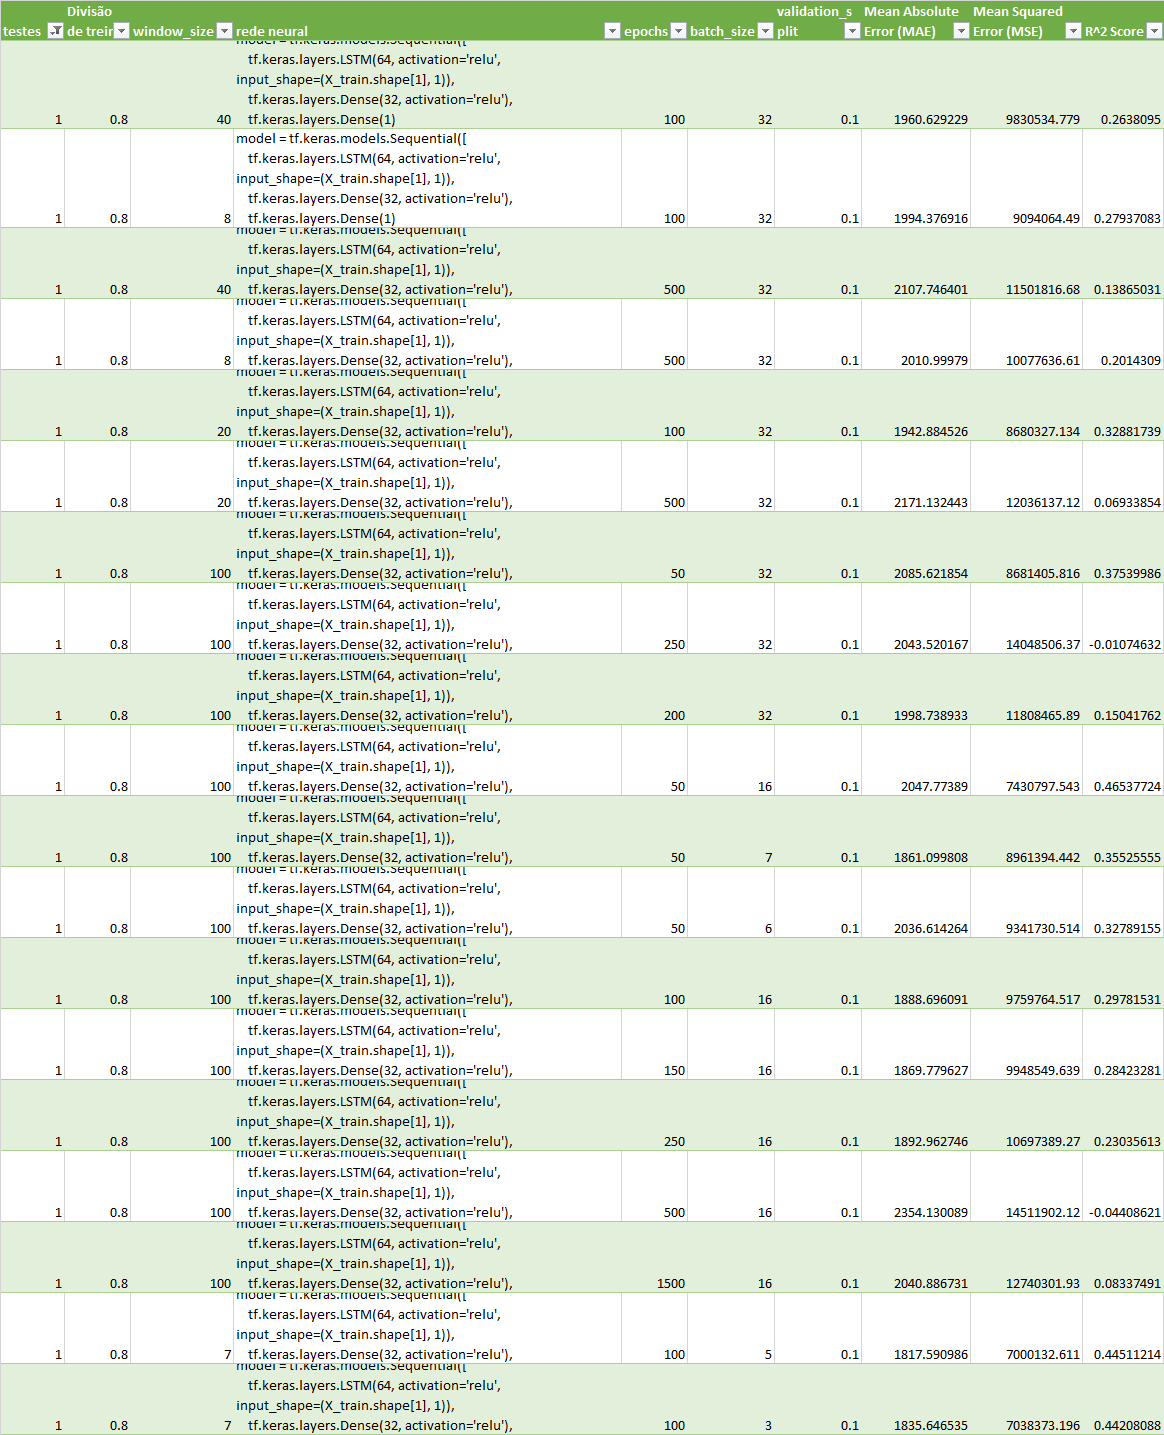

##2. Modelo Random Forest

In [ ]:
# Seguem abaixo as biblitecas necessárias para nossa análise, mas todas elas já constam na lista inicail e forma importadas.

import pandas as pd #biblioteca necessária para análise e manipulação de dados
import numpy as np #essencial para análise númerica complexa e manipulação de dados
import seaborn as sns #biblioteca para visualização de dados
import matplotlib.pyplot as plt #biblioteca para plotagem de gráficos de dados


In [ ]:
# Os dados de venda estão no arqivo do formato csv e serão importados e lidos

original_dataset = pd.read_csv('data.csv')
original_dataset.head()

,Date,Sales,Stock,Price
0,01/12/2018,7388,9,5
1,02/12/2018,4434,23,9
2,03/12/2018,5056,20,5
3,04/12/2018,6146,9,8
4,05/12/2018,6877,5,4


In [ ]:
# Vamos extrair os anos e os meses correspondentes e entender a distribuição deles no conjunto de dados.
ano = original_dataset.iloc[:, 0].str.split('/').str[2]
ano.value_counts()


2022    363
2019    362
2021    360
2020    336
2023    212
2018     30
Name: Date, dtype: int64

In [ ]:
mes = original_dataset.iloc[:, 0].str.split('/').str[1]
mes.value_counts()

07    155
12    150
01    150
03    149
06    149
05    144
02    140
04    137
08    125
10    124
09    120
11    120
Name: Date, dtype: int64

In [ ]:
# Serão separadas todas as linhas da segunda coluna do conjunto original de dados para formar um novo conjunto

dataset = original_dataset.iloc[:,1]
dataset.shape

(1663,)

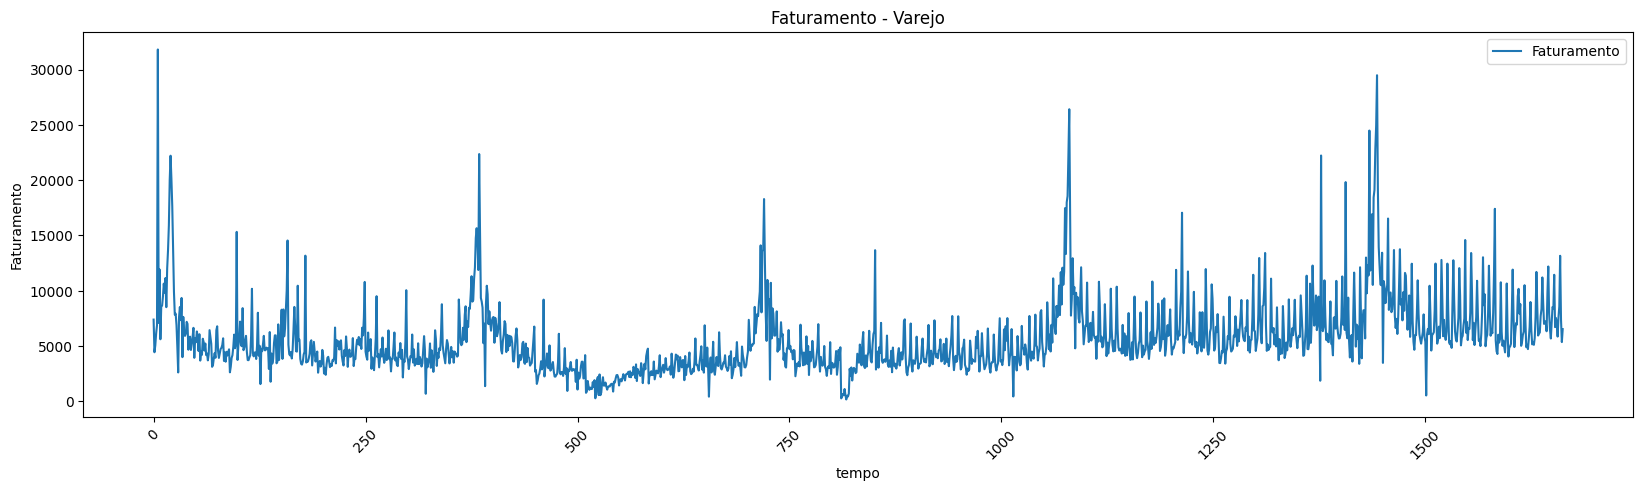

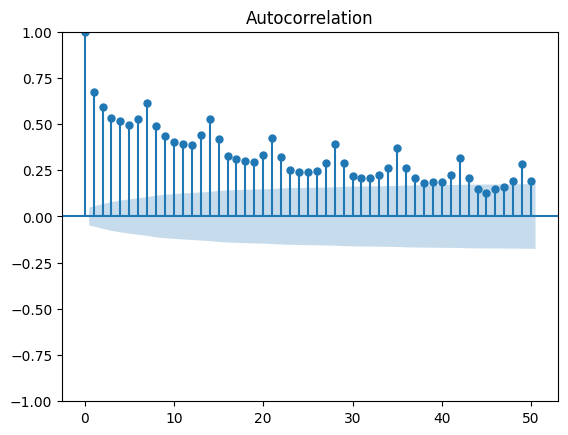

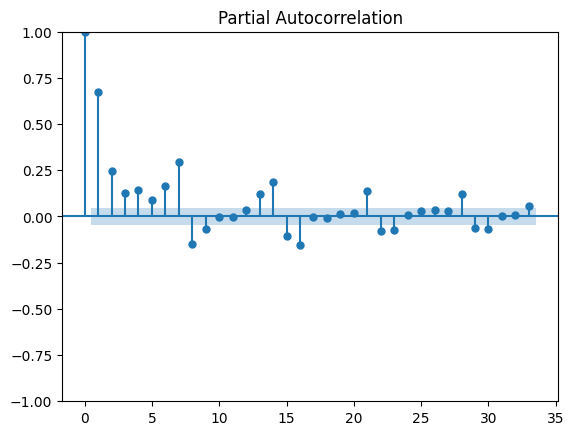

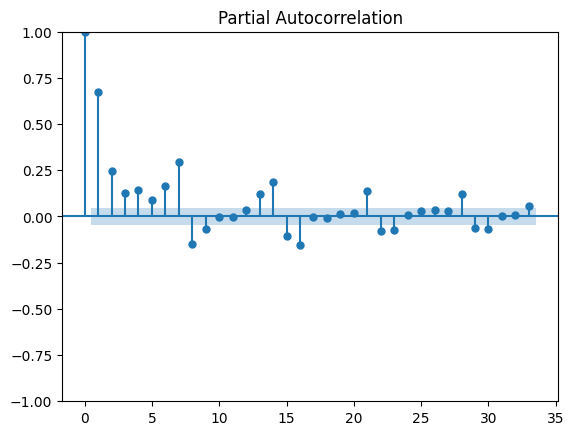

In [ ]:
# Em seguinda, vamos vizualisar a nossa série

plt.figure(figsize=(20,5))
plt.plot(dataset, label='Faturamento')
plt.xlabel("tempo")
plt.ylabel("Faturamento")
plt.title("Faturamento - Varejo")
plt.legend()
plt.xticks(rotation=45) # coloca somente 4 valores no eixo x e rotaciona 45 graus por questões de visualização
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dataset, lags=50)
plt.show()

plot_pacf(dataset)

In [ ]:
# A partir desse passo vamos criar a janela e separar os dados em conjuntos de treino e teste

window = 21
dataSize = len(dataset)
X = []
y = []
for i in range(window, dataSize):
    X.append(dataset.iloc[i-window:i])
    y.append(dataset.iloc[i])
X, y = np.array(X), np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

(1642, 21)
(1642,)


In [ ]:
X[0:5]

array([[ 7388,  4434,  5056,  6146,  6877, 31821,  7082, 11923,  5608,
         8544,  8653,  9461, 10640,  9819, 11147,  8511, 12018, 13662,
        15913, 20019, 22212],
       [ 4434,  5056,  6146,  6877, 31821,  7082, 11923,  5608,  8544,
         8653,  9461, 10640,  9819, 11147,  8511, 12018, 13662, 15913,
        20019, 22212, 20123],
       [ 5056,  6146,  6877, 31821,  7082, 11923,  5608,  8544,  8653,
         9461, 10640,  9819, 11147,  8511, 12018, 13662, 15913, 20019,
        22212, 20123, 17639],
       [ 6146,  6877, 31821,  7082, 11923,  5608,  8544,  8653,  9461,
        10640,  9819, 11147,  8511, 12018, 13662, 15913, 20019, 22212,
        20123, 17639, 13975],
       [ 6877, 31821,  7082, 11923,  5608,  8544,  8653,  9461, 10640,
         9819, 11147,  8511, 12018, 13662, 15913, 20019, 22212, 20123,
        17639, 13975,  9899]])

In [ ]:
y[0:5]

array([20123, 17639, 13975,  9899,  7829])

In [ ]:
# Será definida a semente inicial que vai garantir que os resultados gerados serão sempre os mesmos.

import random
np.random.seed(0)

In [ ]:
# O conjunto de teste será definido pelo parâmetro test_size que costuma variar de acordo com a natureza de dados.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1)

# imprimir
x_train[0:5]

array([[  161,   504,   432,   690,  2937,  2278,  3057,  1877,  2695,
         3020,  2904,  2545,  2632,  4298,  3867,  3488,  5132,  4330,
         3255,  5363,  6265],
       [ 3225,  3407,  3838,  3370,  5243,  3358,  4011,  3757,  3140,
         3438,  4612,  5892,  4666,   678,  3862,  3075,  3382,  3850,
         5231,  3031,  4605],
       [ 3904,  4556,  4417,  7650,  5495,  3404,  4514,  4751,  5885,
         5623,  9452,  5214,  4499,  4606,  4758,  5945,  5817,  7689,
         6628,  5005,  6477],
       [ 5561,  5170,  5811,  5061,  5638,  4735,  6652,  5958,  7536,
        10794,  4492,  4044,  3761,  6215,  4576,  4770,  5622,  2934,
         3959,  3491,  2813],
       [ 6545,  6067, 10449,  7861,  4589,  5988,  6095,  6253,  8201,
        12458,  7224,  5213,  5626,  6748,  5709,  7075, 12784,  9502,
         5883,  7363,  5981]])

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1477, 21)
(1477,)
(165, 21)
(165,)


In [ ]:
#  O modelo criado terá 9 árvores de decisão e o número mínimo de dados (folhas) de 10.

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=9, min_samples_leaf = 10, random_state=0)
regressor.fit(x_train, y_train);

In [ ]:
# O modelo trinado será utilizado para previsão cinco primeiras previsões.

y_pred = regressor.predict(x_test)
y_pred[0:5]

array([ 6057.60661164, 11376.58172686,  4685.8628098 ,  7350.09923464,
        6275.95171255])

Resultados de Teste
RMSE:  1314.4153478503997
MSE:  1727687.7066646875
MAPE:  21.68674673658258 %
R2:  0.7788494585142555


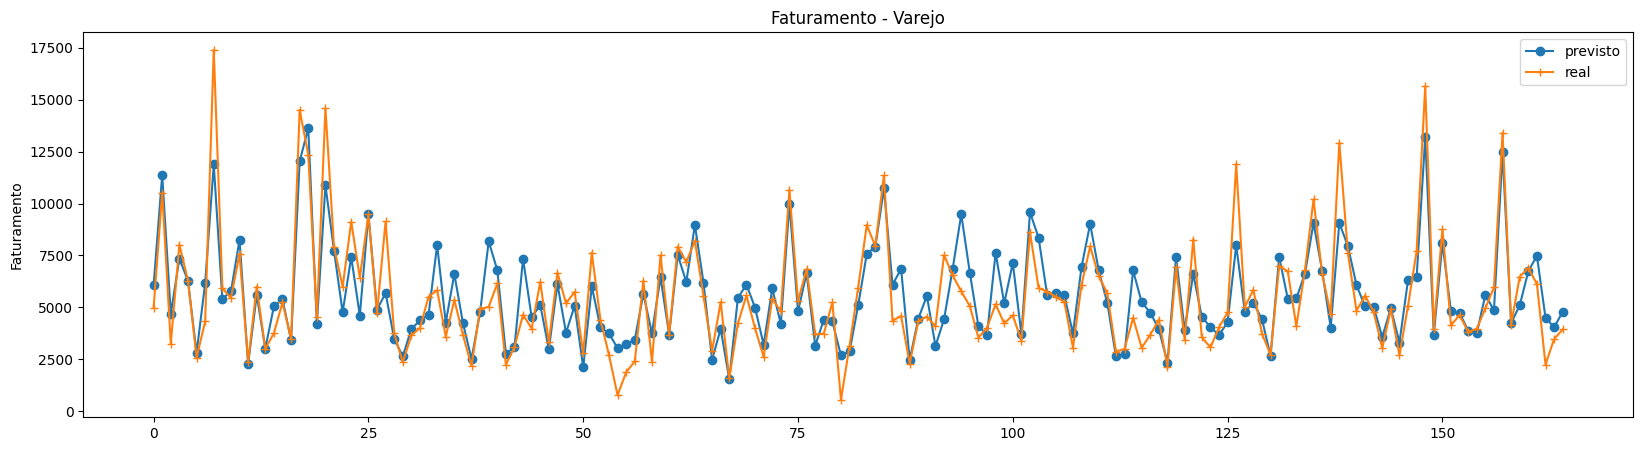

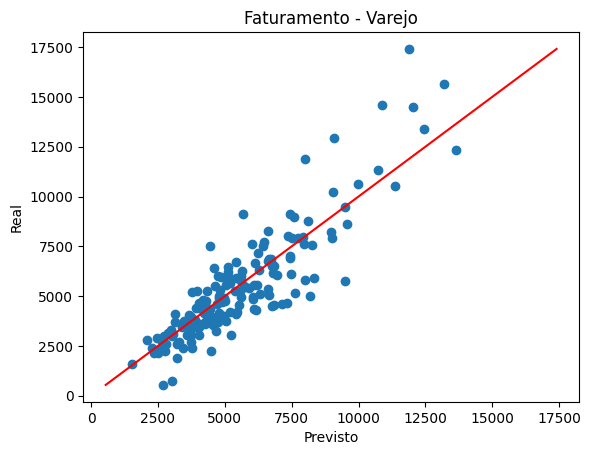

In [ ]:
# Em seguida, será feito o cálculo de métricas de erros utilizadas para avalisação do modelo

from sklearn.model_selection import cross_val_score

def evaluate(y_test, y_pred):
  import math
  from sklearn.metrics import mean_squared_error
  rmse = math.sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE: ', rmse)

  mse = mean_squared_error(y_test, y_pred)
  print('MSE: ',mse)

  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
  print('MAPE: ',mape, '%')

  from sklearn.metrics import r2_score
  r2 = r2_score(y_test, y_pred)
  print('R2: ', r2)

  # Gráfico 1
  plt.figure(figsize=(20,5))
  plt.plot(y_pred, label='previsto', marker='o')
  plt.plot(y_test, label='real', marker='+')
  plt.ylabel("Faturamento")
  plt.title("Faturamento - Varejo")
  plt.legend()
  plt.show()

  # Gráfico 2
  plt.scatter(y_pred,y_test)
  plt.ylabel("Real")
  plt.xlabel("Previsto")
  plt.title("Faturamento - Varejo")

  x = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
  plt.plot(x, x, color='red'); # reta onde y=x (modelo perfeito)

  plt.show()

print('Resultados de Teste')
evaluate(y_test, y_pred)

Resultados de Treino
RMSE:  1412.730234027476
MSE:  1995806.714135327
MAPE:  21.337064011513917 %
R2:  0.7970351728972613


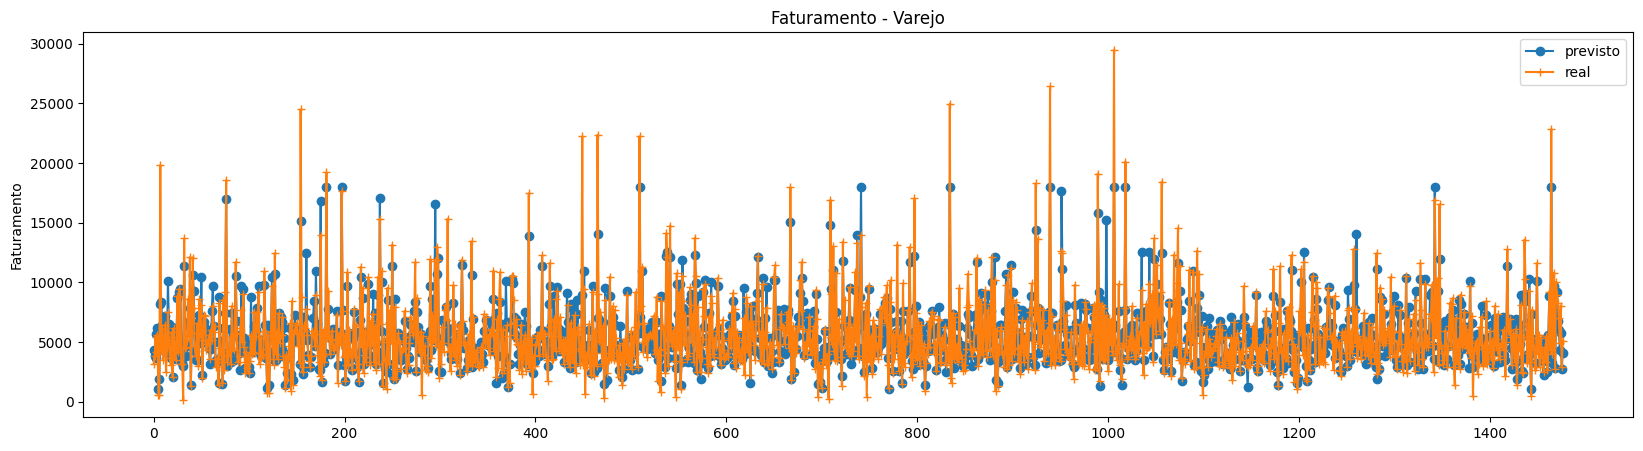

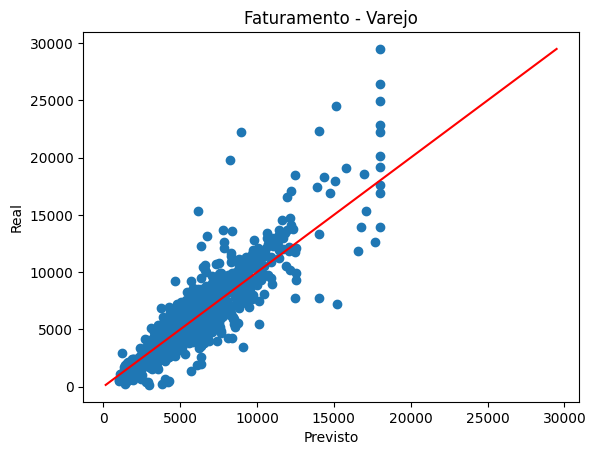

In [ ]:
# Segue avalisação de treino

print('Resultados de Treino')
y_pred_train = regressor.predict(x_train)
evaluate(y_train, y_pred_train)

Os parâmetros usados no TREINAMENTO desse modelo são:

* window_size - 21;

* n_estimators - 9 (indica o número de árvores usadas no treino e treinadas separadamente);

* min_samples_leaf - 10 (indica o número mínimo de amostras em último nó da árvore).

Com esses parâmetros conseguimos os seguintes desempenhos:

*** Mean Absolute Error (MAE): 1412.730234027476

O MAE de aproximadamente 1413 indica que, em média, as previsões do modelo estão desviando do valor real em cerca de 1413 unidades. Quanto menor esse número significa que o modelo é melhor.

*** Mean Squared Error (MSE): 1995806.714135327

O MSE de aproximadamente 1995807 indica que existem alguns pontos com erros importantes, porém comparado com o modelo anterior esse é mais preciso.

*** MAPE (Mean Absolute Percentage Error): 21.337064011513917 %

O MAPE é uma métrica que calcula a média das porcentagens absolutas dos erros. Nesse caso, o erro absoluto é de 21% em relação aos valores reais.

*** R^2 Score: 0.7970351728972613

O R^2 Score de aproximadamente 0.80 indica que cerca de 80% da variabilidade dos dados de saída é capturada pelo modelo. Esse parâmetro varia entre 0 e 1, onde 1 indica que o modelo explica toda a variabilidade. Nesse caso, podemos concluir que o modelo explica bem veriabilidade dos dados, mas ainda assim há em torno de 20% da variabilidades não capturada pelo modelo.

O desempenho de TESTE foi o seguinte:

*** RMSE:  1314.4153478503997

*** MSE:  1727687.7066646875

*** MAPE:  21.68674673658258 %

*** R2:  0.7788494585142555

Comparando os resultados de treino e de teste podemos concluir que as diferença são pequenas. Esse resultado sugere que o modelo está generalizando bem para novos dados.


In [ ]:
lag = dataset.iloc[dataSize-window:dataSize].values
lag

array([ 7228,  6333,  9797, 12191,  7898,  6506,  5677,  7164,  8525,
        8404, 11441,  6707,  7535,  7111,  5851,  7563,  8586, 13159,
        7402,  5354,  6527])

In [ ]:
lag.shape

(21,)

In [ ]:
lag = lag.reshape(1, -1)
lag.shape

(1, 21)

In [ ]:
# Será feita a revisão do primeiro próximo valor
regressor.predict(lag)

array([6731.46269412])

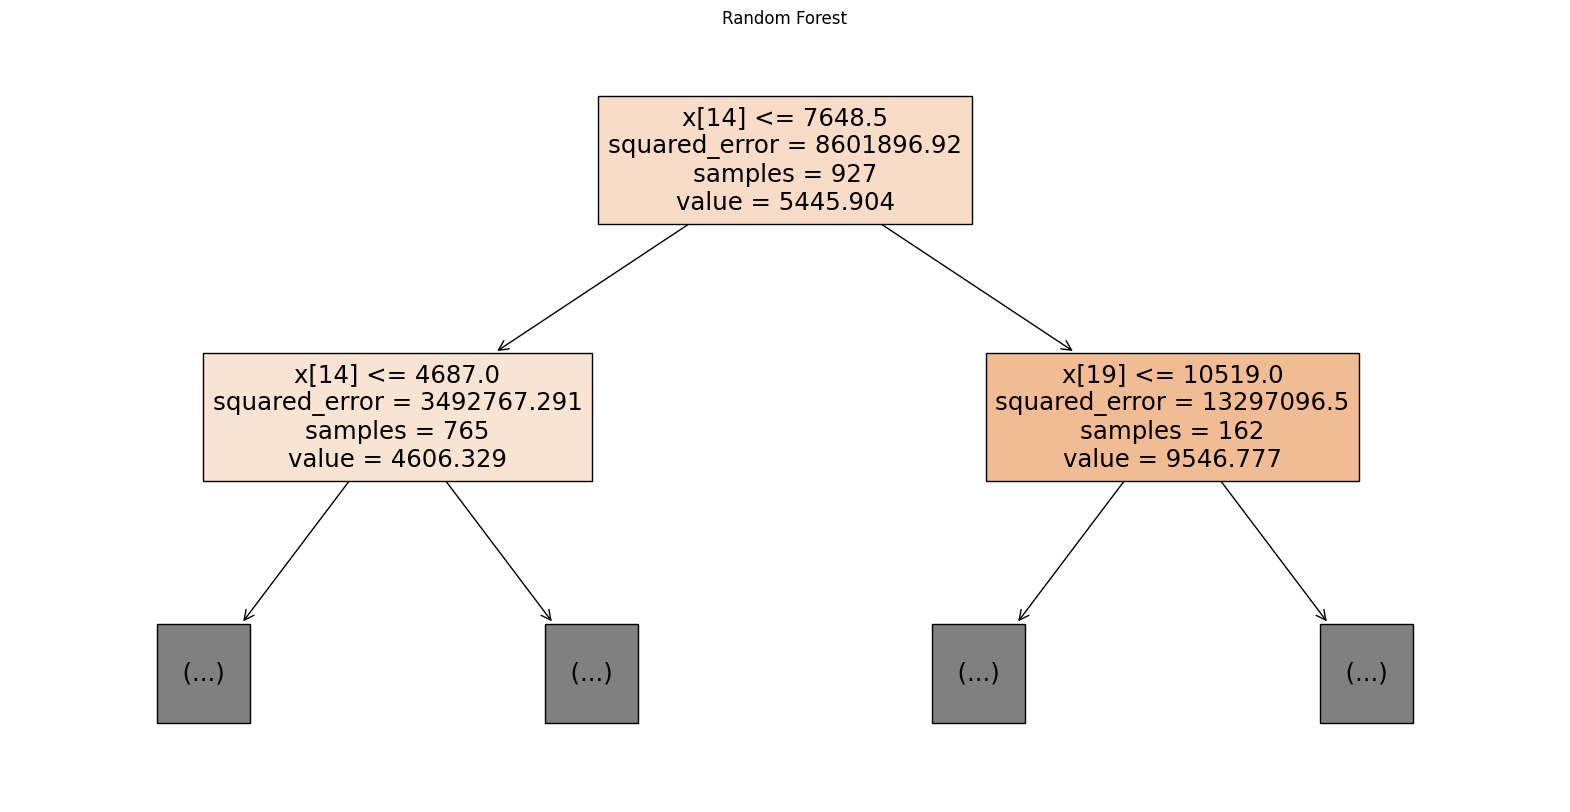

In [ ]:
# Será visualizado o primeiro nível de profundidade da árvore do modelo (max_depth=1)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(regressor[0],max_depth=1, filled=True, class_names=['0', '1'])
plt.title('Random Forest')
plt.show()

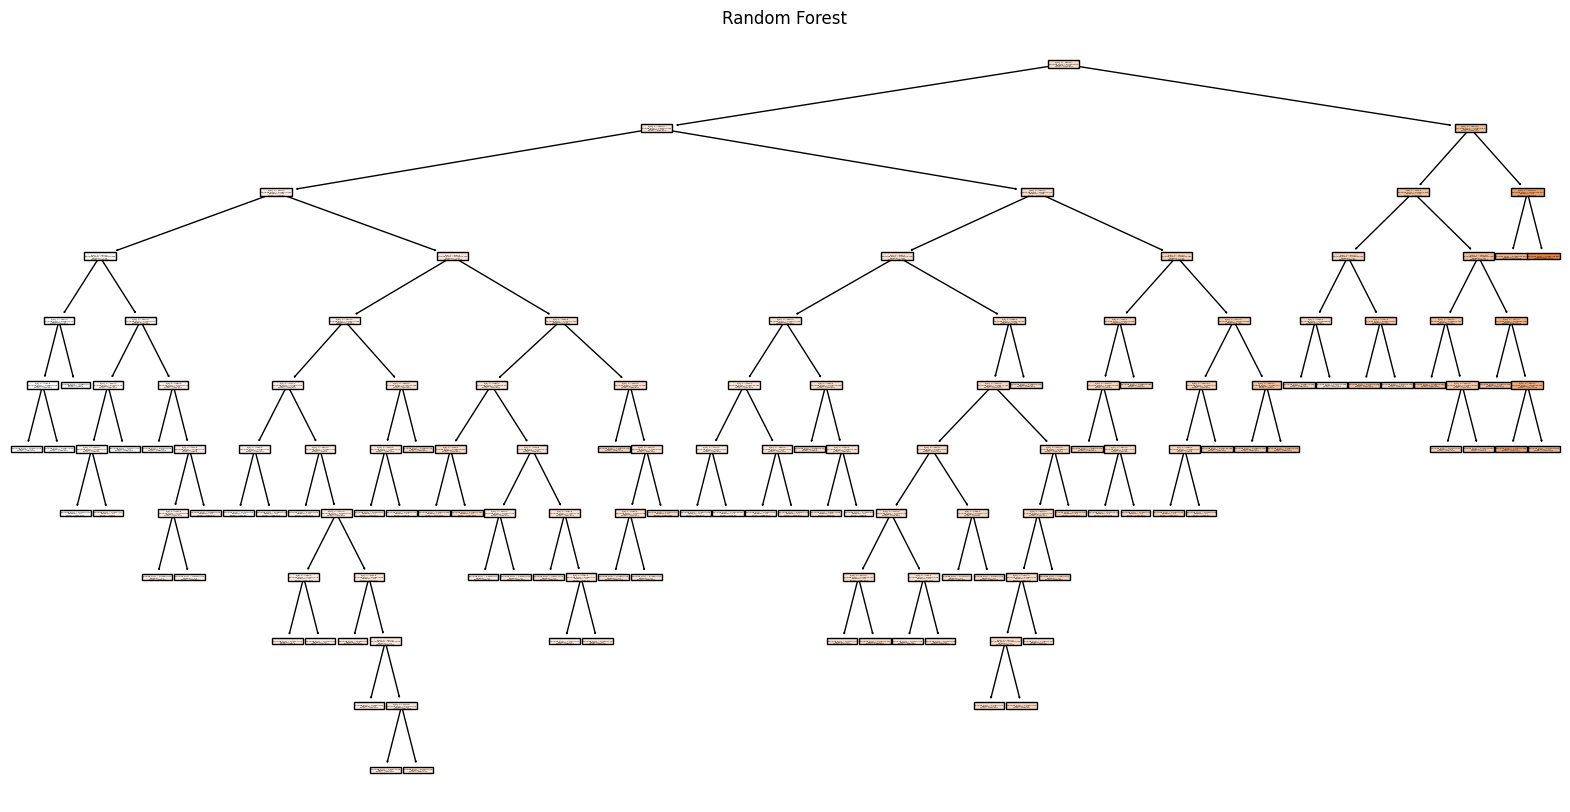

In [ ]:
# Será visualizada a árvore completa

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(regressor[0], filled=True, class_names=['0', '1'])
plt.title('Random Forest')
plt.show()

Segue abaixo a tabela com parâmetros usado nas outras tentativas de treinamento e os resultados obtidos para cada uma.

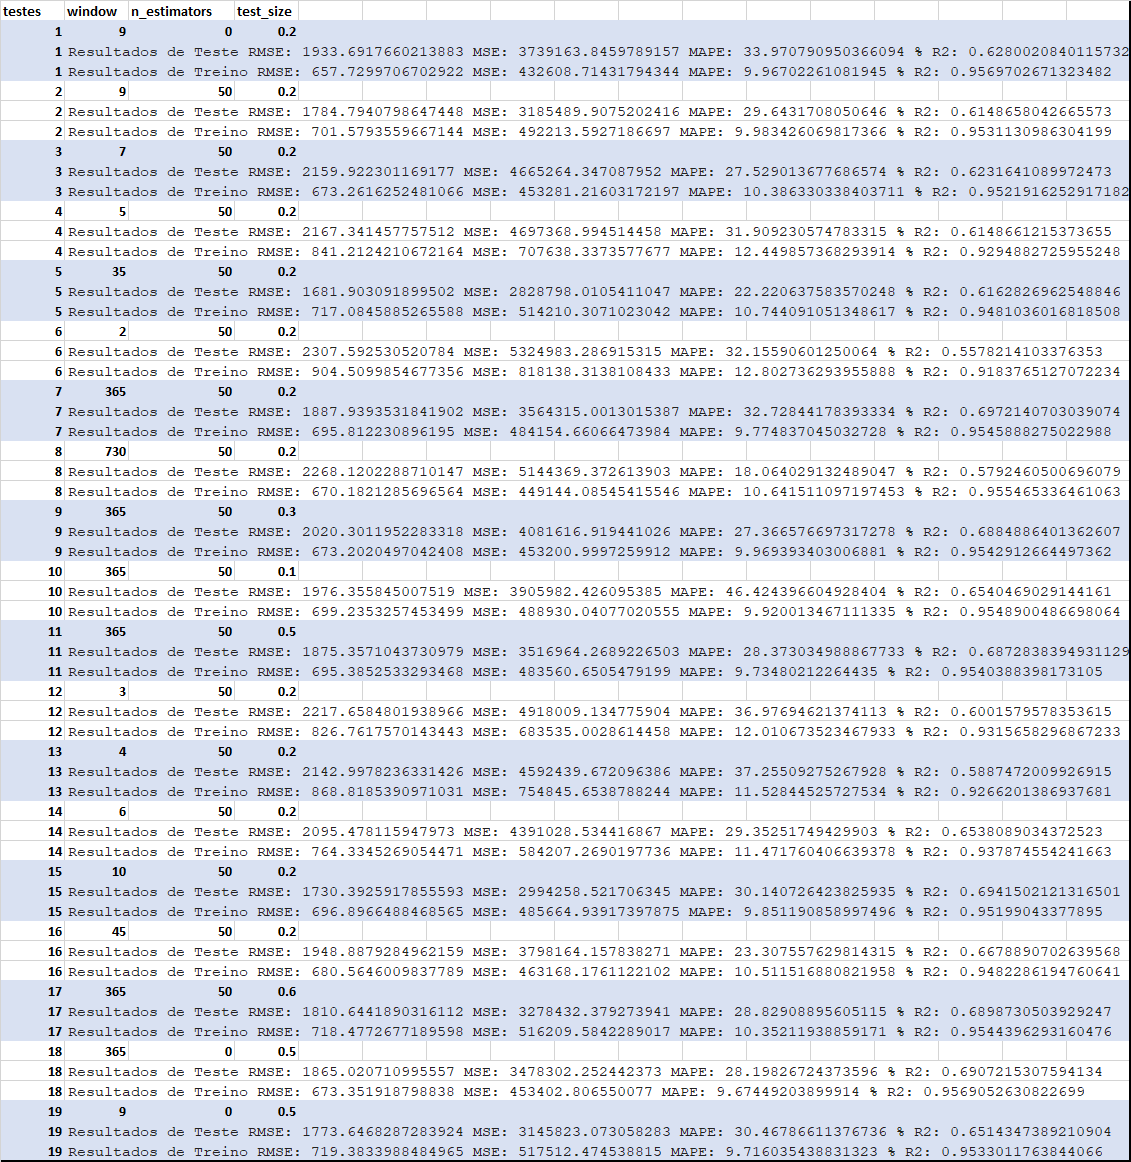

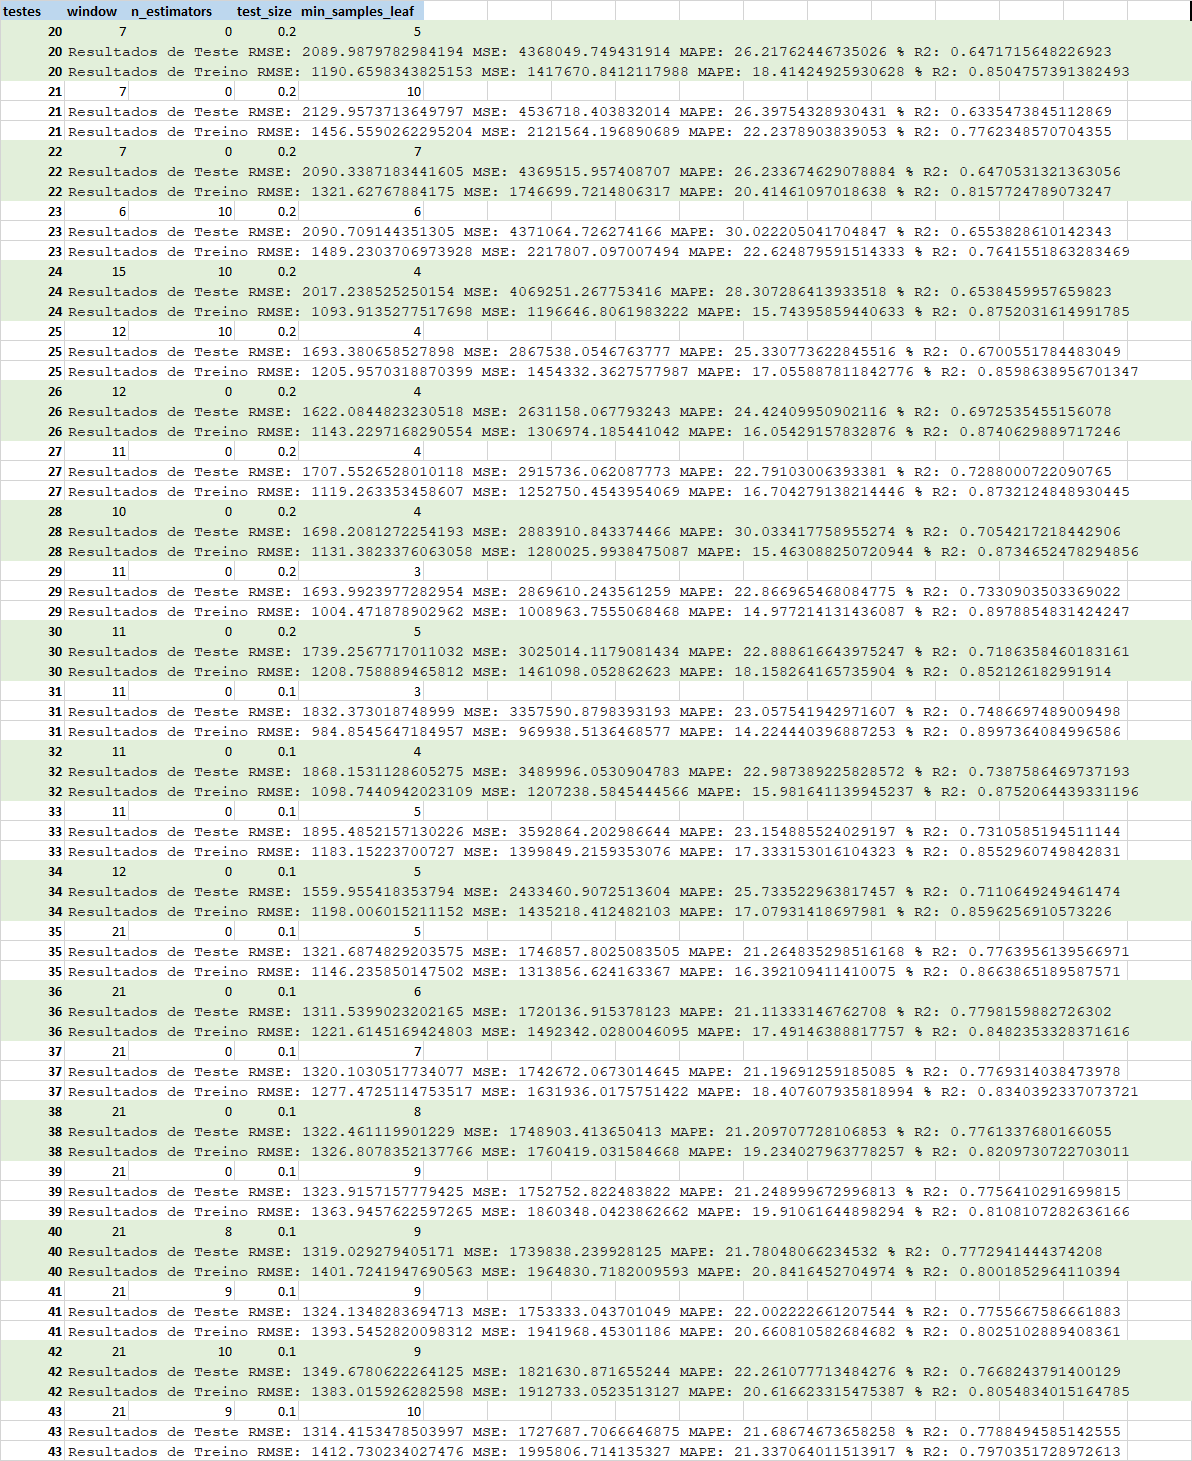


**Conclusão**

No presente estudo, foram explorados e analisados os resultados obtidos a partir da aplicação de dois modelos:
1. Modelo baseado na rede neural
2. Modelo random forest.

A análise de resultados finais concentrou-se nas seguintes métricas de avaliação:
1. Mean Absolute Error (MAE),
2. Mean Squared Error (MSE),
3. Mean Absolute Percentage Error (MAPE), e
4. Coefficient of Determination (R² Score).

Os resultados revelam que o modelo Random Forest tem uma capacidade boa de se ajustar aos dados e que consegue capturar aproximadamente 80% da variabilidade dos dados.

É importante ressaltar que apenas após a inclusão do parâmetro min_samples_leaf foi possível eliminar overfitting do modelo.

Diferente do modelo Random Forest, o modelo baseado em Rede Neural mostrou-se complexo para o problema e sem capacidade significativa de adaptação.

Este estudo contribuiu para uma compreensão melhor como funcionam os modelos de regressão e como a escolha dos hiper parâmetros desempenhou um papel importante na modelagem.